## Otorowiri

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import sys
import os
import pickle
import flopy
import geopandas as gpd
from shapely.geometry import LineString,Point,Polygon,MultiPolygon,MultiPoint,shape

%load_ext autoreload
%autoreload 2

import loopflopy
import loopflopy.utils as utils

modules = utils.list_modules(loopflopy)
#for module in modules: print(module)

os.getcwd()

loopflopy.__file__


'c:\\users\\00105295\\projects\\loopflopy\\loopflopy\\__init__.py'

### 1. Setup Project

In [2]:
name = 'otorowiri'
workspace = '../modelfiles/'
results = '../results/'
figures = '../figures/'
triexe = '../exe/triangle.exe'
mfexe = '../exe/mf6.exe'

from loopflopy.project import Project
project = Project(name, workspace, results, figures, triexe, mfexe)
project.crs = 28350  # UTM zone 50S, EPSG:28350

project.mfexe

'../exe/mf6.exe'

### 2. Structural Model

In [3]:
# A bounding box for structural model
x0, x1 = 320000, 400000
y0, y1 = 6670000, 6780000
z0, z1 = -1500, 400
bbox = [(x0, y0, z0), (x1, y1, z1)]

from loopflopy.spatial_routines import make_bbox_shp
crop_polygon = make_bbox_shp(x0, x1, y0, y1, crs=project.crs, fname = '../data/data_shp/structuralmodel.shp')

In [4]:
# Create Structural Model object
geodata_fname = '../data/data_geology/bore_data_Otorowiri.xlsx'
data_sheetname = 'geodata_elevation'
strat_sheetname = 'strat'
from loopflopy.structuralmodel import StructuralModel
structuralmodel = StructuralModel(bbox, geodata_fname, data_sheetname, strat_sheetname) #spatial and bbox come from the spatial module, excel file and sheet names are user defined

In [5]:
# Clip DEM to structuralmodel
import process_dem

original_asc_path     = '../data/data_elevation/rasters_COP30/output_hh.asc'
crop_polygon_shp_path = '../data/data_shp/structuralmodel.shp'
output_tif_path       = '../data/data_dem/structuralmodel_dem.tif'
#process_dem.model_DEM(original_asc_path, crop_polygon_shp_path, output_tif_path) #only need to do once! About 5min

from loopflopy.dem import DEM
geotiff_fname = '../data/data_dem/structuralmodel_dem.tif'
dem_structural = DEM(geotiff_fname = geotiff_fname)
#dem_structural.plot_geotiff()

In [6]:
help(dem_structural.resample_topo)

Help on method resample_topo in module loopflopy.dem:

resample_topo(mesh, fname, crop_polygon=False, method='nearest', extrapolate_edges=True) method of loopflopy.dem.DEM instance



No special cells
EPSG:28350
EPSG:28350


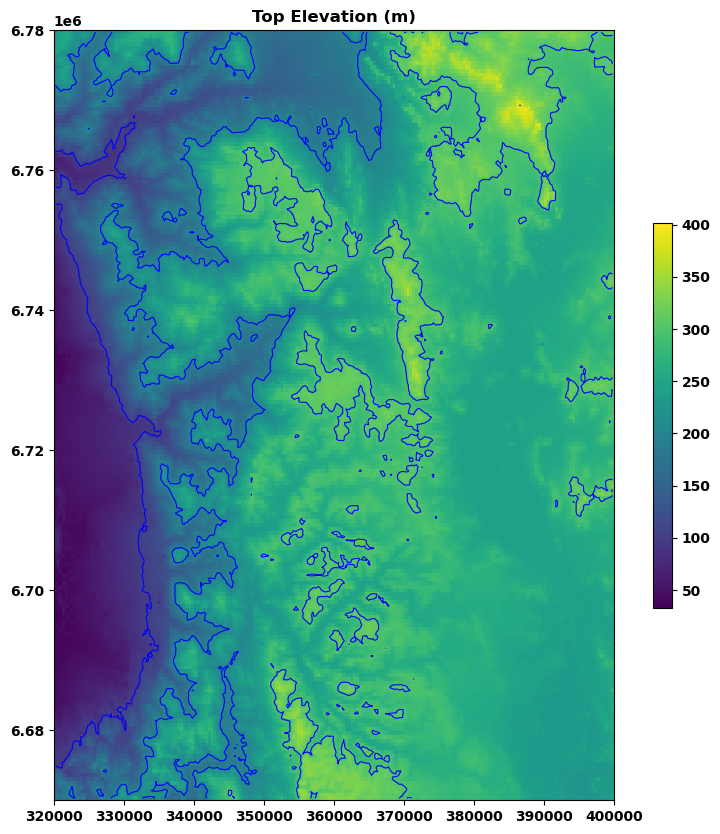

In [7]:
# Resample DEM to raster mesh
from loopflopy.mesh_routines import create_structured_mesh
dem_grid = create_structured_mesh(bbox, ncol = 200, nrow = 200, crs = project.crs)

dem_structural.resample_topo(dem_grid, fname = '../modelfiles/structural_topo.pkl') # only need to run when mesh changes. Take 1-2 minutes
dem_structural.load_topo(fname = '../modelfiles/structural_topo.pkl')
dem_structural.plot_topo(dem_grid, levels = [0, 100, 200, 300, 400, 500, 600, 700])

structuralmodel.topo = dem_structural.topo
structuralmodel.mesh = dem_grid

In [8]:
# Just keep yjis for a bit
#def find_elevation(row):
#    point = Point(row['Easting'], row['Northing'])
#    cell = structuralmodel.mesh.gi.intersect(point)["cellids"][0]
#    z = structuralmodel.topo[cell]
#    return z
#
#df = pd.read_excel(structuralmodel.geodata_fname, sheet_name='geo_boundaries') #Refer to the geology spreadsheet
#df['Ground_dem'] = df.apply(lambda row: find_elevation(row), axis=1)
    

In [9]:
import process_structural

process_structural.geo_boundaries(project, structuralmodel, crop_polygon, simplify_tolerance =1000, node_spacing = 2000)
process_structural.prepare_strat_column(structuralmodel)
process_structural.add_geo_boundaries(structuralmodel)
#process_structural.elevation_fill_all(structuralmodel) #this will fill all the boreholes with DEM elevations
process_structural.elevation_fill_unknown(structuralmodel) #this will fill only the boreholes with no elevation data
process_structural.prepare_geodata(structuralmodel)
process_structural.create_structuralmodel(structuralmodel)

structuralmodel.model.to_file('../modelfiles/structuralmodel') #pickle the model to send to people
structuralmodel.data.to_excel('../modelfiles/structuraldata.xlsx', index=False) # Check the data used for structural model
structuralmodel.strat.to_excel('../modelfiles/structuralstrat.xlsx', index=False) # Check the stratigraphy used for structural model

     sequence    unit    R    G    B   val  lithid Thickness  iconvert     hk  \
0      Ground  Ground  255  255  255     0      -1         -       NaN    NaN   
1  Yarragadee      Kp  172  186  242   124       0       NaN       1.0  100.0   
2  Yarragadee     Kpo  117  128  229   100       1       NaN       0.0    0.1   
3  Yarragadee      Jy  198  217  240 -1000       2       NaN       0.0   10.0   

     vk       ss    sy     Unnamed: 13  
0   NaN      NaN   NaN             NaN  
1  10.0  0.00010  0.10  hk should be 8  
2   0.1  0.00001  0.01             NaN  
3  10.0  0.00001  0.20             NaN  

Updated DataFrame with geo_boundaries written to new sheet: 'geo_boundaries' in file: ../data/data_geology/bore_data_Otorowiri.xlsx
DEM bounds:
  xmin (left):   319999.2808458023
  ymin (bottom): 6669986.956668399
  xmax (right):  400000.3649361293
  ymax (top):    6780029.0232758615
  CRS:           EPSG:28350
DataFrame coordinate extents:
  Easting:  min = 333143.0, max = 375240.0
  


Updated DataFrame written to new sheet: 'structuralmodel_data' in file: ../data/data_geology/bore_data_Otorowiri.xlsx
1.6.13


c:\Users\00105295\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


In [10]:
'''import pyvista
from LoopStructural.visualisation import Loop3DView
view = Loop3DView(structuralmodel.model)
view.plot_surface(structuralmodel.model['Yarragadee'], [124])
#view.plot_model_surfaces()
view.plot_data(structuralmodel.model['Yarragadee'])
view.set_scale(zscale = 10)
view.show()'''

"import pyvista\nfrom LoopStructural.visualisation import Loop3DView\nview = Loop3DView(structuralmodel.model)\nview.plot_surface(structuralmodel.model['Yarragadee'], [124])\n#view.plot_model_surfaces()\nview.plot_data(structuralmodel.model['Yarragadee'])\nview.set_scale(zscale = 10)\nview.show()"

In [11]:
z0 = -300 # just for plotting. Make sure within bbox of structural model
z1 = 300   # just for plotting. Make sure within bbox of structural model
nh, nz = 90, 90 # plotting resolution

transect_x = [375000]#, 400000, 410000]
# DONGARA LINE - 6750000
# ENEABBA LINE - 6700000
#transect_y = [6760000, 6730000]# 6700000]
#structuralmodel.plot_xtransects(transect_x, ny = 80, nz = 120)#, x1 = 6520000, z0 = -2000) 
#structuralmodel.plot_ytransects(transect_y, nx = 80, nz = 120, z0 = -1000) 

transect_y = [6710000, 6702000]
#structuralmodel.plot_ytransects2(transect_y, nx = 60, nz = 60, dz = 10, x0 = 335000, x1 = 375000, z0 = -300, z1 = 400) #x0 = 335000, x1 = 352000, z0 = -200, z1 = 300


In [12]:
#for i in range(len(spatial.xsections)):
#    start = spatial.xsections[i][0]
#    end   = spatial.xsections[i][1]

#    structuralmodel.plot_xytransect(title = spatial.xsection_names[i], start = start, end = end, z0 = z0-1000, z1 = z1+1000, nh = nh, nz = nz)

#structuralmodel.contour_bottom(spatial, contour_interval = 10) #unit = 'Kp', 

### 4. Surface Refinement

In [13]:
from loopflopy.surfacerefinement import SurfaceRefinement
surfacerefinement = SurfaceRefinement(structuralmodel, nrow = 200, ncol = 200)
surfacerefinement.create_surf_lith_raster(structuralmodel) # This takes about 48seconds

Max ground level =  311.0
Min ground level =  169.0
No special cells
number of cells in plan =  40000
   0. Creating xyz array...
Time taken Block 0 (creating xyz array) =  5.471361
   1. Evaluating structural model...
len(xyz) =  5840000
Time taken Block 1 (Evaluate model) =  32.743888
   2. Creating geo model layers...
stop_array shape (4, 40000)
nlay =  146
ncpl =  40000
nlg number of geo layers =  3
Time taken Block 2 create geomodel layers  1.045846
   3. Evaluating geo layer thicknesses...
Time taken Block 3 tiny bit 0.0
   4. Creating flow model layers...
Time taken Block 4 create flow model layers =  0.054725
   5. Calculating gradients...
Time taken Block 5 gradients=  4.066379


In [14]:
# Create surfaces from the structural model
# This will create surfaces for each stratigraphic unit in the model
structuralmodel.make_surfaces()
bot_parm = structuralmodel.surfaces[1]

     
Creating surface for feature: Ground, lithid -1, value: 0
number of vertices =  2663
     
Creating surface for feature: Yarragadee, lithid 0, value: 124
number of vertices =  2400
     
Creating surface for feature: Yarragadee, lithid 1, value: 100
number of vertices =  2711


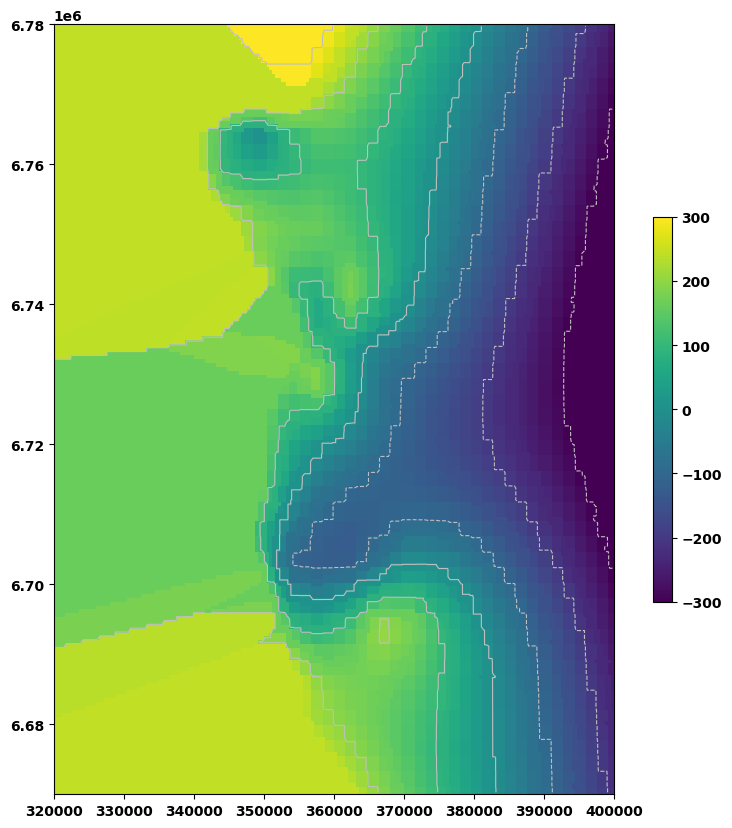

In [15]:
#dir(surfacerefinement.geomodel) #.plot_surface(surfacerefinement.geomodel.top_geo)
# Bottom of Parmelia
array = bot_parm #structuralmodel.topo - bot_parm
title = 'title'
surfacerefinement.mesh.plot_surface_array(array, structuralmodel, vmin = -300, vmax = 300)


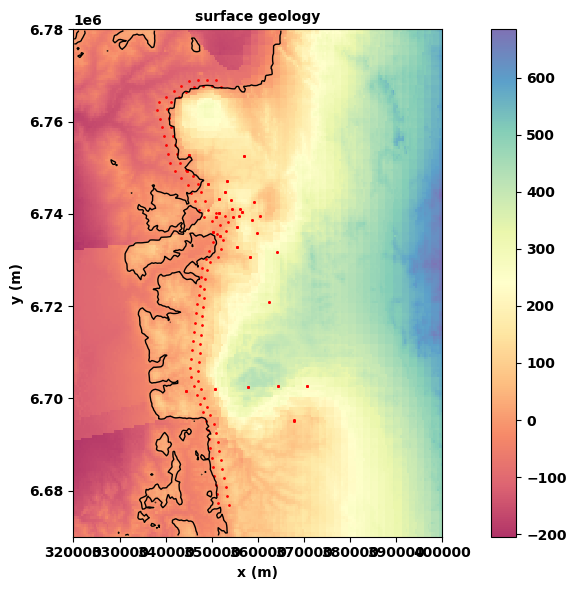

c:\users\00105295\projects\loopflopy\loopflopy\surfacerefinement.py:116: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in contour.collections:


In [16]:
array1 = structuralmodel.topo # 1D
array2 = bot_parm # 1D
surfacerefinement.array_intersection(project, structuralmodel, array1, array2, plot_datapoints = True)

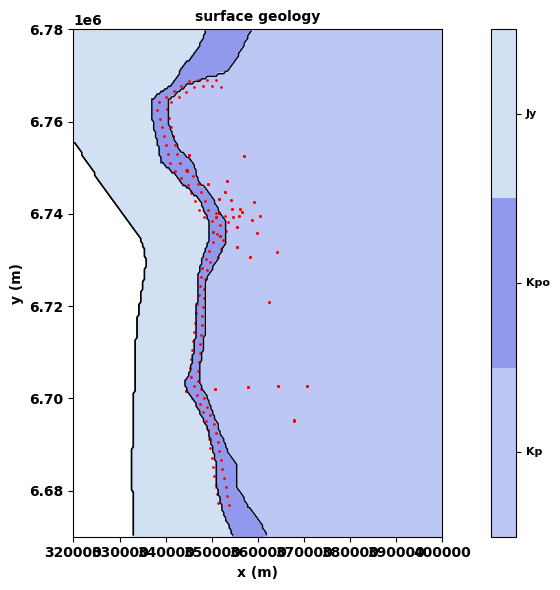

c:\users\00105295\projects\loopflopy\loopflopy\surfacerefinement.py:167: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in contour.collections:


In [17]:
surfacerefinement.surface_contours(project, structuralmodel, plot_datapoints = True)

### 5. Model boundary

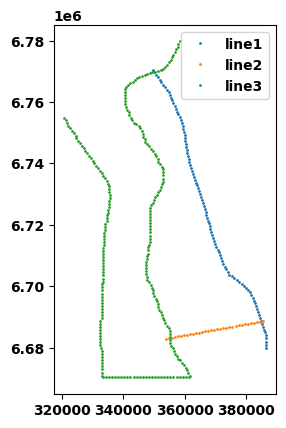

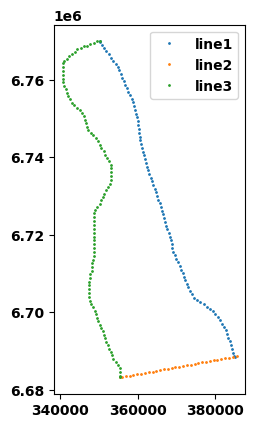

Line 1 start: POINT (350164.2572153285 6769825), end: POINT (384941.9994871997 6688578.607368894)
Line 2 start: POINT (355400 6683187.098433047), end: POINT (385456.633948645 6688672.529796141)
Line 3 start: POINT (350164.2572153285 6769825), end: POINT (355400 6683187.098433047)


In [18]:
import process_boundary
raw_lines, labels = process_boundary.gather_boundary_linestrings(project)
process_boundary.plot_linestrings(raw_lines, labels)
trimmed_lines = process_boundary.trim_boundary_linestrings(raw_lines)
process_boundary.plot_linestrings(trimmed_lines, labels)
snapped_lines = process_boundary.snap_linestring_endpoints(trimmed_lines, tolerance=1000)  # 5 units tolerance, adjust as needed
model_boundary_poly = process_boundary.make_boundary_polygon(trimmed_lines, snapped_lines)

### 6. Spatial

POLYGON ((361337.20725018514 6735522.680110534, 361318.55532478204 6735525.34676506, 361300.2371096979 6735529.756794962, 361282.41518154956 6735535.871060632, 361265.24771234096 6735543.635297142, 361248.8870656651 6735552.98059585, 360589.151451948 6735972.229061367, 360574.4827576252 6735982.500582804, 359975.5522891828 6736443.188638042, 359972.66517840134 6736445.4518035585, 359627.74982986867 6736720.970266216, 359160.85397186875 6737035.591168093, 358646.0471174668 6737374.582637623, 358631.7419482652 6737384.935738192, 358618.4057506354 6737396.510296069, 358606.14248842536 6737409.21608047, 358595.04776129295 6737422.954042004, 358178.78923114884 6737987.677366506, 358168.802181669 6738002.582821196, 358160.19113841595 6738018.3233317, 357803.21527111484 6738746.661997532, 357802.45015107194 6738748.240553889, 357439.64677841234 6739505.1979318485, 356985.1587132632 6739946.094619135, 356649.4186185305 6740144.445396702, 355987.0582307656 6740394.382825348, 355969.0571409932 6

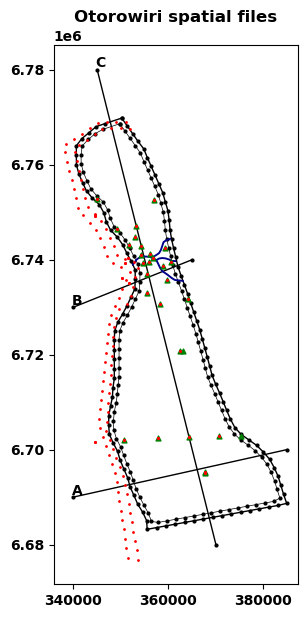

In [19]:
from loopflopy.spatial import Spatial
spatial = Spatial(epsg = project.crs)

import process_spatial
process_spatial.model_boundary(spatial, boundary_buff = 1000, simplify_tolerance = 0, node_spacing = 2000)
process_spatial.geo_bores(spatial)
process_spatial.obs_bores(spatial)
process_spatial.pump_bores(spatial)
process_spatial.arrow(spatial, node_spacing = 200, buffer_distance = 200, threshold = 100)
#process_spatial.rivers(spatial, node_spacing = 200, buffer_distance = 200, threshold = 100)
#process_spatial.outcrop(spatial, node_spacing = 200, buffer_distance = 200, threshold = 100)

spatial.xsection_names = ['A', 'B', 'C']
spatial.xsections = [
                     [(340000, 6690000),(385000, 6700000)], 
                     [(340000, 6730000),(365000, 6740000)],
                     [(345000, 6780000),(370000, 6680000)]
                     ]

#extent = [[330000, 370000],[6740000, 6770000]] #[[342000, 370000],[6725000, 6745000]] # extent[[x0,x1], [y0,y1]]
extent = [[330000, 370000],[6680000, 6770000]]
process_spatial.plot_spatial(spatial, structuralmodel,
                 labels = False, # Bore ids
                 obsbores = False, 
                 pumpbores = False, 
                 geobores = True, 
                 rivers = False, # thre three river
                 arrow = True, # Just arrowsmith
                 structuralmodel_data = True,
                 xsections = True,
                 #extent = extent # Just hash out to see the whole model
                 ) 

In [20]:
m = spatial.obsbore_gdf.explore()#location=[-31.4, 115.8], zoom_start=11, popup = 'ID')
#m = folium.Map(location=[52.0, 4.0], zoom_start=6) 
spatial.model_boundary_gdf.explore(m=m, fill = False)
#spatial.faults_gdf.explore(m=m, color = 'red')

### 3. Mesh

In [21]:
import process_recharge

#model boundary and flow model mesh which are made above
model_boundary = gpd.read_file('../data/data_shp/model_boundary.shp')
#mesh.mesh_to_gdf()
#mesh.gdf

# ONLY need to do this when the model boundary changes

veg_multipolygons_by_year = process_recharge.clip_veg_to_model(spatial, model_boundary) # Just need to do when boundary changes! Or could clip to structural model then don't need to do it all the time? 
#print(veg_multipolygons_by_year)

#create figures to visualise vegetation changes over time
#process_recharge.print_clipped_veg_figures(model_boundary)
#process_recharge.project_veg_onto_mesh(mesh, model_boundary)

Saved: ../data/data_woody/clipped_woody/vegetation_clipped_1972.shp
Saved: ../data/data_woody/clipped_woody/vegetation_clipped_1972.shp
Saved: ../data/data_woody/clipped_woody/vegetation_clipped_1977.shp
Saved: ../data/data_woody/clipped_woody/vegetation_clipped_1980.shp
Saved: ../data/data_woody/clipped_woody/vegetation_clipped_1985.shp
Saved: ../data/data_woody/clipped_woody/vegetation_clipped_1988.shp
Saved: ../data/data_woody/clipped_woody/vegetation_clipped_1989.shp
Saved: ../data/data_woody/clipped_woody/vegetation_clipped_1991.shp
Saved: ../data/data_woody/clipped_woody/vegetation_clipped_1992.shp
Saved: ../data/data_woody/clipped_woody/vegetation_clipped_1995.shp
Saved: ../data/data_woody/clipped_woody/vegetation_clipped_1998.shp
Saved: ../data/data_woody/clipped_woody/vegetation_clipped_2004.shp
Saved: ../data/data_woody/clipped_woody/vegetation_clipped_2005.shp
Saved: ../data/data_woody/clipped_woody/vegetation_clipped_2006.shp
Saved: ../data/data_woody/clipped_woody/vegetati

arrow_nodes
number of cells in plan =  5537


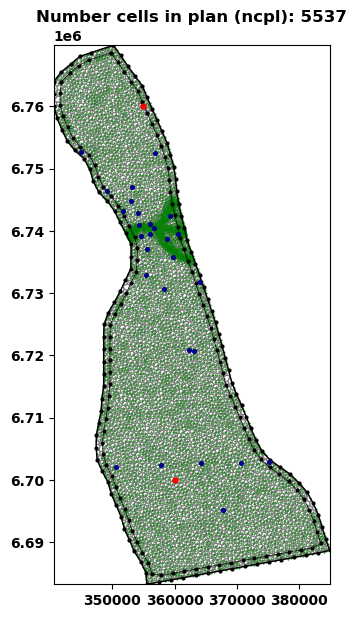

In [22]:
from loopflopy.mesh import Mesh
# groups: obs, wel, chd, ghb, poly 


special_cells = {
                 #'rivers': ['arrow'],
                 #'wel': ['pumpbores'], 
                 'obs': ['obsbores'],
                 'poly': ['arrow'],
                 'multipoly': ['2006']
                 }
mesh = Mesh(plangrid = 'vor', special_cells = special_cells) # special cells to identify as arguements

mesh.modelmaxtri = 300000 # was 400000
mesh.boundmaxtri = 999999999
mesh.angle = 32   # minimum triangle angles
mesh.radius1 = 200 # radius of inner circle around pumping bores
mesh.radius2 = 600 # radius of outer circle around pumping bores
mesh.boremaxtri = 99999999

mesh.create_bore_refinement(spatial)

node_list = ['arrow_nodes']#'bore_refinement_nodes']
polygon_list = ['model_boundary_poly', 'inner_boundary_poly']

mesh.prepare_nodes_and_polygons(spatial, node_list, polygon_list)
mesh.create_mesh(project, spatial)

print('number of cells in plan = ', mesh.ncpl)

xlim = extent[0]
ylim = extent[1]
features = ['wel', 'obs', 'arrow']
mesh.plot_cell2d(spatial, features, xlim = None, ylim = None, nodes = False, labels = False) # Just exclude xlim, ylim if plotting whole thing

### 4. Find Cell IDs of spatial features

Group =  obs ['obsbores']
flag = 1
Group =  poly ['arrow']
flag = 2
poly_arrow_cells
Group =  multipoly ['2006']
flag = 3
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_angrot', '_botm', '_build_grid_geometry_info', '_cache_dict', '_cell1d', '_cell2d', '_copy_cache', '_crs', '_edge_set', '_grid_type', '_has_ref_coordinates', '_idomain', '_iverts', '_laycbd', '_lenuni', '_load_settings', '_ncpl', '_neighbors', '_nlay', '_polygons', '_prjfile', '_require_cache_updates', '_set_neighbors', '_top', '_units', '_vertices', '_verts', '_xoff', '_xul_to_xll', '_yoff', '_yul_to_yll', '_zcoords', 'angrot', 'angrot_radians', 'attribs_from_namfile_header', 'botm', 'cell1d', 'cell2d', 'cell

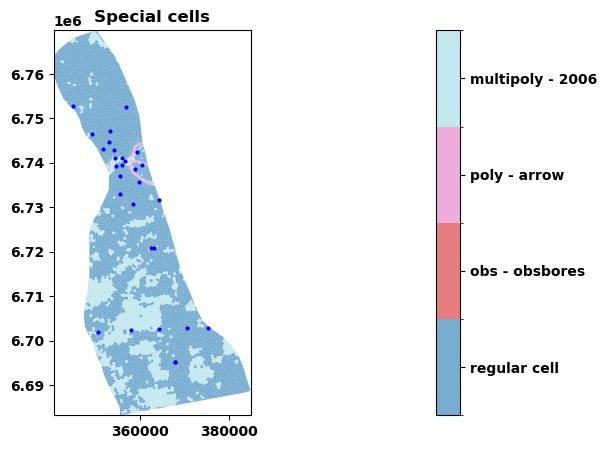

In [23]:
mesh.locate_special_cells(spatial, threshold = 0.4) #the threshold here controls how much of a cell should be covered by the polygon to create a 'special cell'
mesh.plot_feature_cells(spatial) #, xlim, ylim)

Clipped GeoTIFF saved to: ../Data/data_dem/Otorowiri_Geomodel_DEM.tif
-9999.0


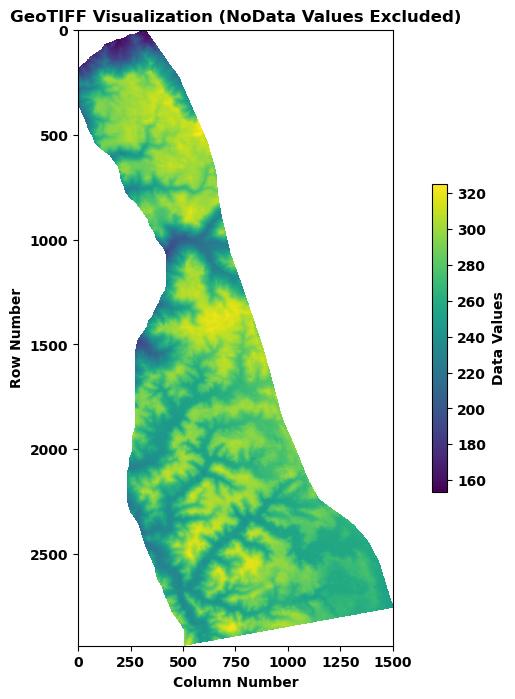

None
EPSG:28350


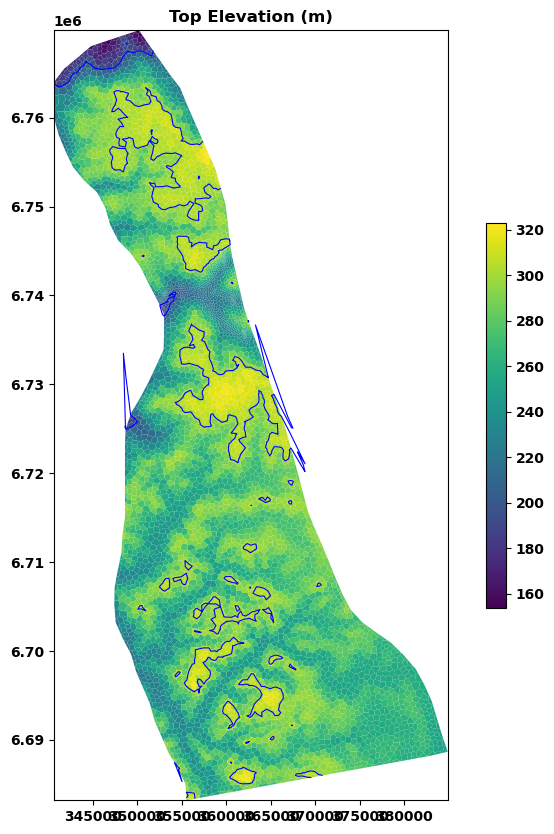

In [24]:
##here clip model to the geological model boundary
original_tiff_path    = '../data/data_dem/structuralmodel_dem.tif' #Otorowiri_Model_DEM.tif'
crop_polygon_shp_path = '../data/data_shp/model_boundary.shp'
output_tiff_path      = '../Data/data_dem/Otorowiri_Geomodel_DEM.tif'
process_dem.crop_geotiff(original_tiff_path, crop_polygon_shp_path, output_tiff_path)

dem_geomodel = DEM(geotiff_fname = output_tiff_path)
dem_geomodel.plot_geotiff()

#resample DEM to mesh
dem_geomodel.resample_topo(mesh, fname = '../modelfiles/geomodel_topo.pkl') # only need to run when mesh changes. Take 1-2 minutes
dem_geomodel.load_topo(fname = '../modelfiles/geomodel_topo.pkl')
dem_geomodel.plot_topo(mesh, levels = [0, 100, 200, 300, 400, 500, 600, 700])

### 6. Geomodel

In [26]:
# Set up Geomodel (lithological block model of cells)
scenario = 'example'
vertgrid = 'con'    # {voxel: nlay, z0, z1} {con:   nls, res} {con2:  nls, res, max_thick}
z0, z1 = -300, 300 

from loopflopy.geomodel2 import Geomodel
geomodel = Geomodel(scenario, vertgrid, z0, z1, nls = 4, res = 1, nlg = 1) # include nlg if you only want some of the top geo layers included in flow model
geomodel.evaluate_structuralmodel(mesh, structuralmodel)
geomodel.create_model_layers(mesh, structuralmodel, dem_geomodel)

   0. Creating xyz array...
Time taken Block 0 (creating xyz array) =  2.815715

   1. Evaluating structural model...
len(xyz) =  3322200
Time taken Block 1 (Evaluate model) =  15.436611

   2. Creating geo model layers...
ncpl =  5537
nlg number of geo layers =  1
[50 50 25]
     
Creating surface for feature: Ground, lithid -1, value: 0
number of vertices =  2663
len filtered z  2663  i.e. without NaN or inf
(array([212.9973491 , 213.81243865, 220.49396833, 221.15292549,
       223.21224213, 223.66614342, 225.78419844, 227.23015944,
       227.28844484, 227.33918031, 228.67687543, 229.20204798,
       229.56308524, 230.06364504, 230.8772246 , 231.66120847,
       231.78638617, 232.00774988, 232.13398457, 232.2562933 ,
       232.75398413, 232.99120267, 233.83785089, 234.30655003,
       234.69204903, 235.20710468, 235.59381167, 235.91332436,
       235.99531651, 236.58587138, 236.61078612, 236.79289023,
       237.59710789, 237.96720505, 238.30091159, 238.6758407 ,
       239.0048662

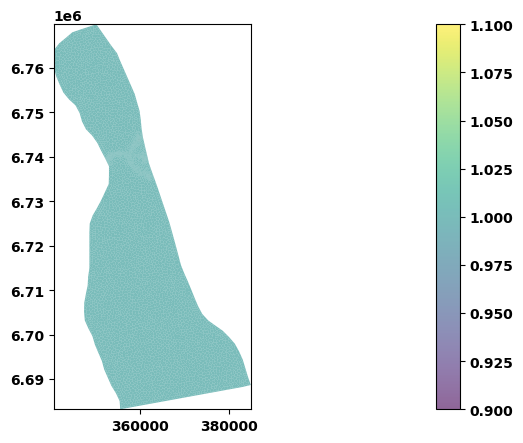

In [27]:
geomodel.plot_surface(geomodel.idomain_geo) # Yellow plots negative or zero thickness

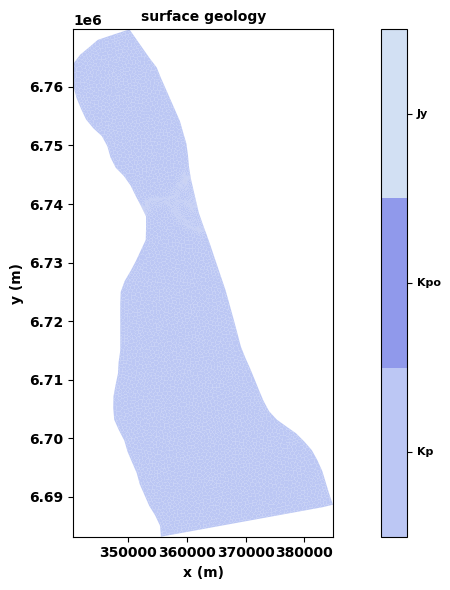

c:\users\00105295\projects\loopflopy\loopflopy\geomodel2.py:640: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in contour.collections:


In [28]:
# Surface lithology
geomodel.get_surface_lith()
geomodel.geomodel_plan_lith(spatial, mesh, structuralmodel)

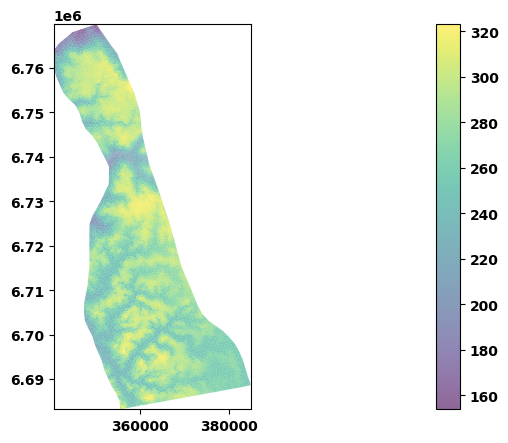

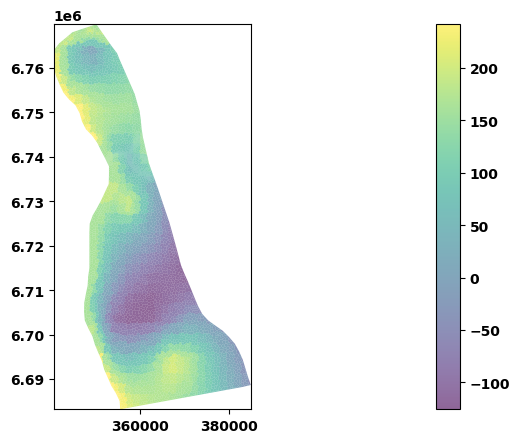

In [29]:
# Geomodel top, bottom of layer 0
geomodel.plot_surface(geomodel.top_geo)
geomodel.plot_surface(geomodel.botm_geo[0])


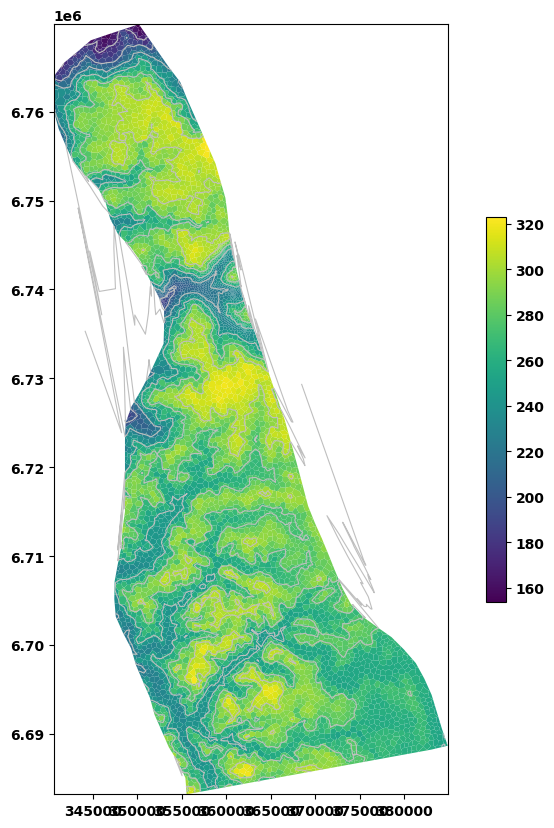

In [30]:
# Different way of plotting top
array = geomodel.top_geo
mesh.plot_surface_array(array, structuralmodel)

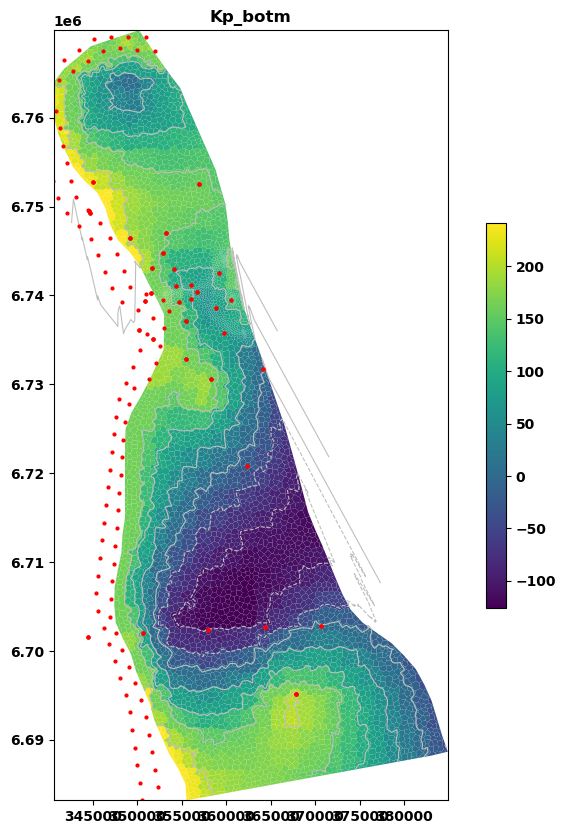

In [31]:
# Bottom of Parmelia
array = geomodel.botm_geo[0] # Botm Kp
title = 'Kp_botm'
mesh.plot_surface_array(array, structuralmodel, title = title, plot_data = True, lithcode = 'Kp')

In [32]:
# Parmelia thickness
Kp_thick = geomodel.top_geo - geomodel.botm_geo[0] 
print('Kp has ', np.sum(Kp_thick < 0), ' negative thickness values')
print('Kp has min geo thickness of ', np.min(Kp_thick), ' m')

Kp has  0  negative thickness values
Kp has min geo thickness of  1.0  m


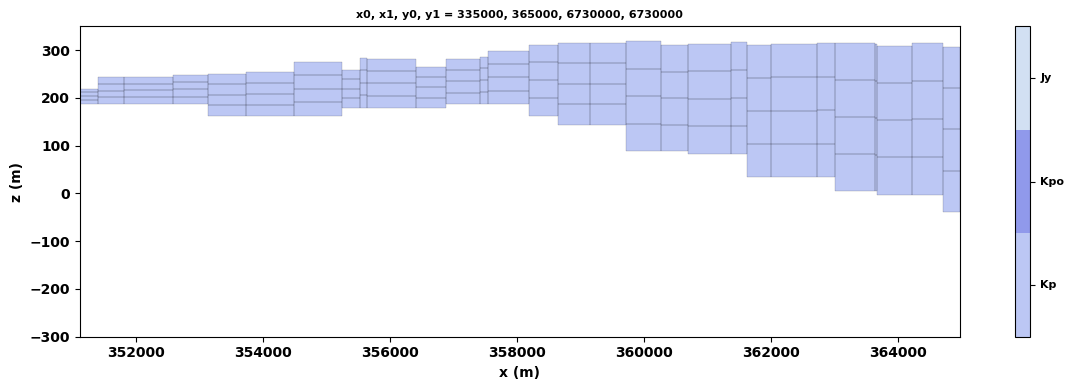

In [33]:
# Geomodel transect
y0, y1 = 6730000, 6730000
geomodel.geomodel_transect_lith(structuralmodel, spatial, y0=y0, y1=y1, x0 = 335000, x1 = 365000, z0 = -300, z1 = 350)# z0 = -200, z1 = 300


### 7. Assign hydrogeological parameters to geomodel cells

In [34]:
# FILL CELL PROPERTIES
props = pd.read_excel(structuralmodel.geodata_fname, sheet_name = 'strat')
props = props.drop(index=[0]).reset_index()#inplace=True) # drop first row as it is ground
geomodel.hk_perlay = props.hk.tolist()
geomodel.vk_perlay = props.vk.tolist()
geomodel.ss_perlay = props.ss.tolist()
geomodel.sy_perlay = props.sy.tolist()
geomodel.iconvert_perlay = [0., 0., 0.] #props.iconvert.tolist() # #

geomodel.fill_cell_properties(mesh)
print(geomodel.hk_perlay)
print(geomodel.iconvert_perlay)  # Check the properties are filled correctly
props


   6. Filling cell properties...
ang1 shape  (4, 5537)
22148
angle1 shape  (22148,)
Time taken Block 6 Fill cell properties =  0.0
[100.0, 0.1, 10.0]
[0.0, 0.0, 0.0]


,index,sequence,unit,R,G,B,val,lithid,Thickness,iconvert,hk,vk,ss,sy,Unnamed: 13
0,1,Yarragadee,Kp,172,186,242,124,0,NaN,1.0,100.0,10.0,0.00010,0.10,hk should be 8
1,2,Yarragadee,Kpo,117,128,229,100,1,NaN,0.0,0.1,0.1,0.00001,0.01,NaN
2,3,Yarragadee,Jy,198,217,240,-1000,2,NaN,0.0,10.0,10.0,0.00001,0.20,NaN


### 8. Filter and prepare groundwater spreadsheets

In [35]:
'''import process_filtering
# Create a bore list from the DWER bore spatial data to extract everything possible from WIR (this will then be iterative depending on model boundary changes)
process_filtering.create_bore_list()

# Trim the data from the large DWER bore data extract to the Otorowiri Shapefile boundary (spatial filter)
geomodel_shapefile = '../data/data_shp/model_boundary_polygon.shp'
bores_in_model = process_filtering.trim_obs_to_shape(geomodel_shapefile)

# For all the bores contained within the Otorowiri model bounds, assign the aquifer based on screen or bore depth
process_filtering.create_merged_obs(bores_in_model)
process_filtering.fill_bore_elevations()
process_filtering.assign_aquifer(mesh, geomodel)

# create the dataframes that will be used for the obs file in flopy - both transient and steady state
process_filtering.filtered_transient_obs(geomodel_shapefile)
process_filtering.extract_steady_state()

# if data needs to be visualised, hydrographs can be made for all the wells with timeseries data
# and 
#process_observations.plot_hydrograph(df_boredetails, spatial)
#process_filtering.plot_seasonal_flows(geomodel_shapefile)'''

"import process_filtering\n# Create a bore list from the DWER bore spatial data to extract everything possible from WIR (this will then be iterative depending on model boundary changes)\nprocess_filtering.create_bore_list()\n\n# Trim the data from the large DWER bore data extract to the Otorowiri Shapefile boundary (spatial filter)\ngeomodel_shapefile = '../data/data_shp/model_boundary_polygon.shp'\nbores_in_model = process_filtering.trim_obs_to_shape(geomodel_shapefile)\n\n# For all the bores contained within the Otorowiri model bounds, assign the aquifer based on screen or bore depth\nprocess_filtering.create_merged_obs(bores_in_model)\nprocess_filtering.fill_bore_elevations()\nprocess_filtering.assign_aquifer(mesh, geomodel)\n\n# create the dataframes that will be used for the obs file in flopy - both transient and steady state\nprocess_filtering.filtered_transient_obs(geomodel_shapefile)\nprocess_filtering.extract_steady_state()\n\n# if data needs to be visualised, hydrographs can 

### 8. Prepare Data for Flowmodel

#### DRN

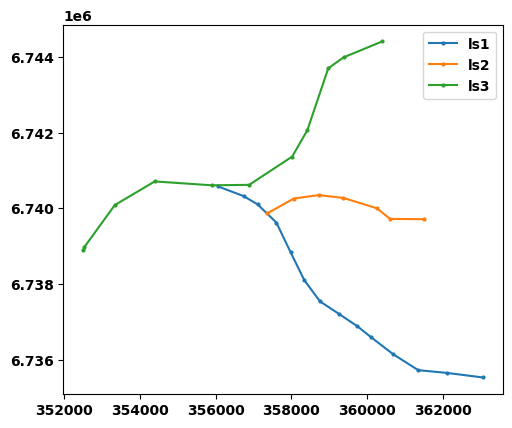

Number of drain cells =  133


In [36]:
from process_data import *
data = Data()

# DRAIN
drain_linestrings = data.process_drn_linestrings(spatial)
drn_ibd, drn_cellids, drn_lengths = data.get_drain_cells(drain_linestrings, geomodel)
data.make_drain_rec(geomodel, drn_cellids, drn_lengths)

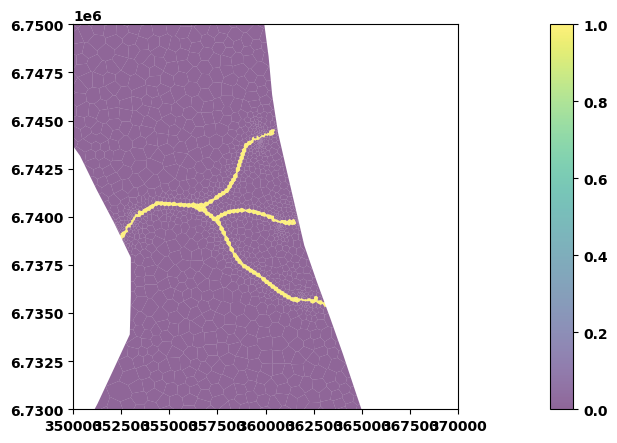

In [37]:
geomodel.plot_surface(drn_ibd, xlim = [350000, 370000], ylim = [6730000, 6750000]) # z0 = -200, z1 = 300

#### CHD

West x-coordinate of drain cells: 352466.16682862054
Westernmost drain cell index: 482
Head in CHD cell : 197.25498962402344


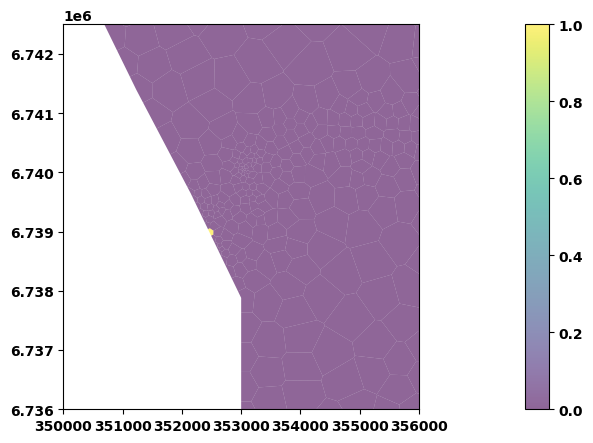

In [38]:
data.process_chd(geomodel, mesh)
geomodel.plot_surface(data.chd_ibd, xlim = [350000, 356000], ylim = [6736000, 6742500]) 

#### IC / RCH / EVT 

In [39]:
print(flopy.__version__)

data.process_ic(geomodel)
data.process_rch(geomodel)
data.process_evt(geomodel)


3.9.3


In [40]:
'''import process_surfaceflows

continuous_df = pd.read_excel('../data/data_surfacewater/174345/WaterLevelsContinuousForSiteCrossTab.xlsx')
discrete_df = pd.read_excel('../data/data_surfacewater/174344/WaterLevelsDiscreteForSiteCrossTab.xlsx')

# Plot the surface flow data
process_surfaceflows.plot_surfaceflows(continuous_df, discrete_df)

# Calculate what needs to be calculated for the model...'''


"import process_surfaceflows\n\ncontinuous_df = pd.read_excel('../data/data_surfacewater/174345/WaterLevelsContinuousForSiteCrossTab.xlsx')\ndiscrete_df = pd.read_excel('../data/data_surfacewater/174344/WaterLevelsDiscreteForSiteCrossTab.xlsx')\n\n# Plot the surface flow data\nprocess_surfaceflows.plot_surfaceflows(continuous_df, discrete_df)\n\n# Calculate what needs to be calculated for the model..."

### 9. Groundwater observations

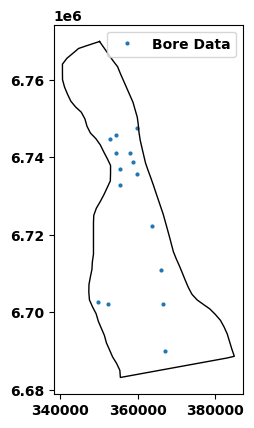

,Site Ref,Collect Date,Collect Month,Collect Year,Depth Measurement Point,Static water level (m),Water level (AHD) (m),Water level (SLE) (m),Site Short Name,Easting,Northing,Elevation_DEM,zobs,Derived WL (mAHD),Season,Sample timeframe
0,61711381,1969-06-30,6,1969,Ground level,25.91,209.090,NaN,9,349762.01,6702688.44,250.058762,231.768762,224.148762,Wet,1969_Wet
1,61711382,1969-06-30,6,1969,Ground level,16.76,213.670,NaN,10 (No.2),352269.02,6702226.45,255.148697,240.823697,238.388697,Wet,1969_Wet
2,61712824,1969-09-15,9,1969,Ground level,28.04,NaN,NaN,5 849,366618.02,6702134.46,249.459351,227.359351,221.419351,Wet,1969_Wet
3,61712850,1969-06-30,6,1969,Ground level,48.77,NaN,NaN,Bore,367043.03,6689968.47,274.338226,243.858226,225.568226,Wet,1969_Wet
4,61712866,1969-06-30,6,1969,Ground level,62.79,19.510,NaN,Bore,363811.03,6722277.47,275.898773,235.053773,213.108773,Wet,1969_Wet
5,61712877,1969-06-30,6,1969,Ground level,48.77,NaN,NaN,Bore,365935.01,6710898.45,278.230713,245.465713,229.460713,Wet,1969_Wet
6,70111706,1969-06-30,6,1969,Ground level,91.44,NaN,NaN,Bore,354409.02,6745612.49,299.811890,244.946890,208.371890,Wet,1969_Wet
7,70118002,1969-10-01,10,1969,Top of casing,8.53,214.584,NaN,AR7,357945.03,6741087.48,224.346420,167.956420,215.816420,Wet,1969_Wet
8,70118003,1969-10-01,10,1969,Top of casing,15.85,215.399,NaN,AR9,359751.05,6735767.49,233.731552,142.291552,217.881552,Wet,1969_Wet
9,70118006,1969-10-30,10,1969,Top of casing,-2.68,211.962,NaN,AR12(ART),354317.04,6741006.49,210.864594,129.194594,213.544594,Wet,1969_Wet


In [41]:
#df = pd.read_csv('../data/data_waterlevels/obs/cleaned_obs_bores_KB.csv')
df = pd.read_excel('../data/data_waterlevels/obs/06_Steady_state_groundwater_obs.xlsx')
df = df[df['zobs'].notna()]

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Easting, df.Northing), crs=project.crs)
fig, ax = plt.subplots() 
ax.plot(gdf.geometry.x, gdf.geometry.y, 'o', ms = 2, label = 'Bore Data')  # You can set color, linestyle, etc.
x, y = spatial.model_boundary_poly.exterior.xy
ax.plot(x, y, '-', ms = 2, lw = 1, color='black')
ax.set_aspect('equal')
ax.legend()
plt.show()

df

In [42]:
import process_observations
gdf = process_observations.make_obs_gdf(df, geomodel, mesh, spatial)

print(gdf.columns)


All geometries are within the polygon.
Index(['id', 'Collect Date', 'Collect Month', 'Collect Year',
       'Depth Measurement Point', 'Static water level (m)',
       'Water level (AHD) (m)', 'Water level (SLE) (m)', 'Site Short Name',
       'x', 'y', 'Elevation_DEM', 'z', 'Derived WL (mAHD)', 'Season',
       'Sample timeframe', 'geometry', 'icpl', 'ground', 'model_bottom',
       'zobs-bot', 'cell_disv', 'cell_disu', '(lay,icpl)', 'lay', 'obscell_xy',
       'obscell_z', 'obs_zpillar', 'geolay'],
      dtype='object')


In [43]:
from loopflopy.observations import Observations
observations = Observations(gdf)
observations.make_recarray() # makes recarray for flowmodel

observations.obs_rec

[[61711381, 'head', 4044],
 [61711382, 'head', 3840],
 [61712824, 'head', 2821],
 [61712850, 'head', 10349],
 [61712866, 'head', 1936],
 [61712877, 'head', 2107],
 [70111706, 'head', 7019],
 [70118002, 'head', 5890],
 [70118003, 'head', 12308],
 [70118006, 'head', 11365],
 [70118009, 'head', 6520],
 [70118010, 'head', 12497],
 [70118014, 'head', 12645],
 [70118016, 'head', 13098],
 [70118017, 'head', 12985]]

### 10. Create and run steady-state flow model

In [44]:
# I've made your own flowmodel script as I'm sure you'll find the LoopFlopy one a bit too restricitive.
# Now you can change the flowmodel however you want!

from Otorowiri_flowmodel import *

scenario = 'steadymodel'
fm = Flowmodel(scenario, project, data, observations, mesh, geomodel)
utils.print_object_details(fm)

Methods:
get_watertable
plot_plan
plot_transect
plot_watertable
run_flowmodel
write_flowmodel

Variables
data
geomodel
lith
logk11
logk33
mesh
observations
project
scenario


In [45]:
fm.geomodel.iconvert # Check the iconvert is set correctly

array([0., 0., 0., ..., 0., 0., 0.])

In [46]:
# Write and run flow model files
sim = fm.write_flowmodel(chd = True, 
                         wel = False, 
                         obs = True, #put false to not record heads at the chosen cells
                         rch = True, 
                         evt = True, 
                         drn = True, 
                         ghb = False, 
                         xt3d = True,
                         staggered = False, # True made "fully connected". "False" is essentially DISV.
                        )

fm.run_flowmodel(sim)

   Writing simulation and gwf for  steadymodel  ...
xt3d =  True
mf6 executable expected:  ../exe/mf6.exe
   Time taken to write flow model =  9.762979
Running simulation for  steadymodel  ...
Model success =  True
   run_time =  6.130065
['DISU', 'NPF', 'IC', 'CHD_0', 'RCH_0', 'EVT_0', 'OBS_0', 'OC']
head results shape  (1, 22148)


Node one based =  17667 Node zero based =  17666
XYZ problem =  360047.7501280822 6739666.8727102 134.39984099070244
cell width approx  351.4097251453204
cell length approx  227.904784838669
cell thickness 26.558903376261355
lay, icpl (3, 1055)


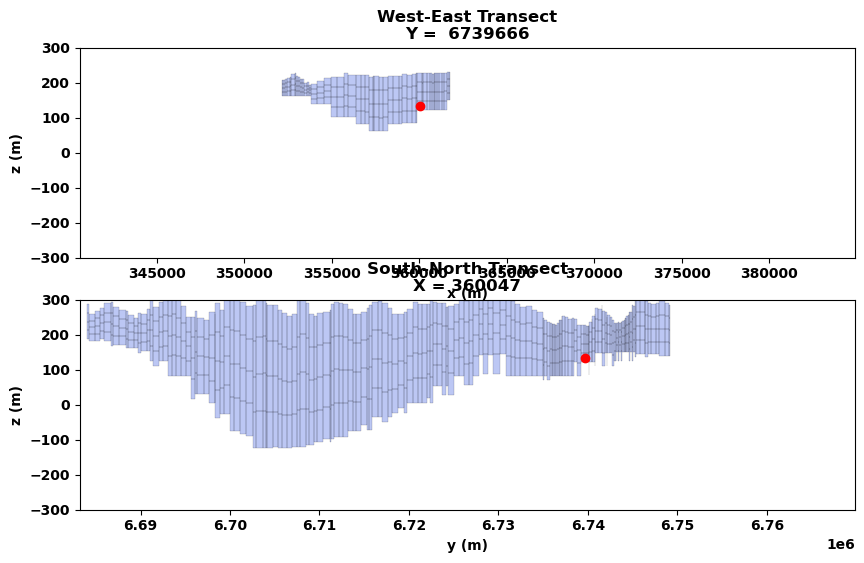

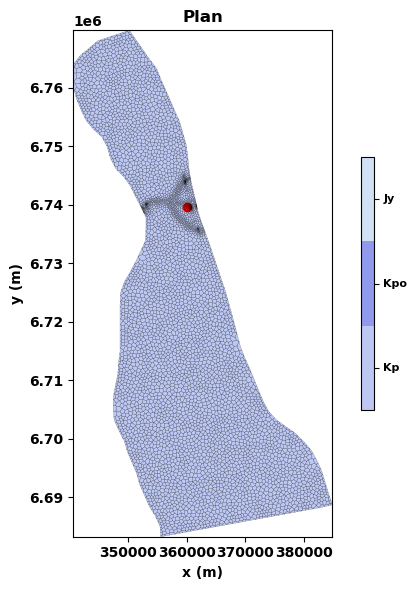

In [47]:
utils.plot_node(17667-1, geomodel, structuralmodel, spatial, sim, scenario, features) # array needs to be a string of a property eg. 'k11', '

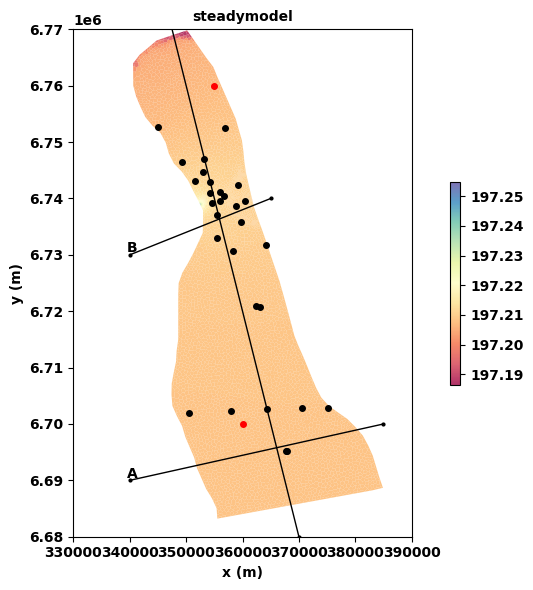

In [48]:
watertable = fm.get_watertable(geomodel, fm.head)

extent = [[330000, 390000],[6680000, 6770000]]
fm.plot_watertable(spatial, mesh, geomodel, fm, watertable, extent = extent, xsections = True,)#vmin = -10, vmax = 150)#, extent, vmin, vmax

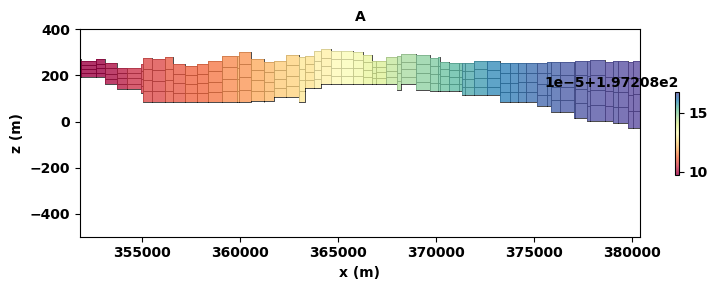

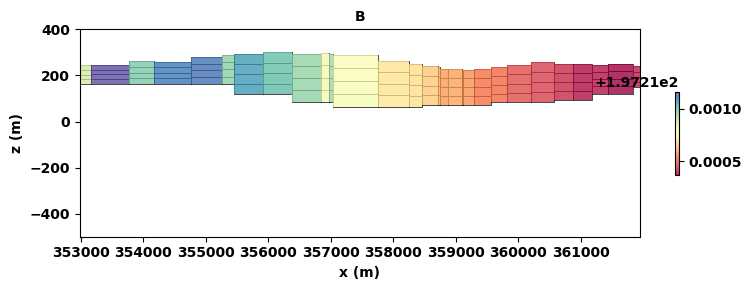

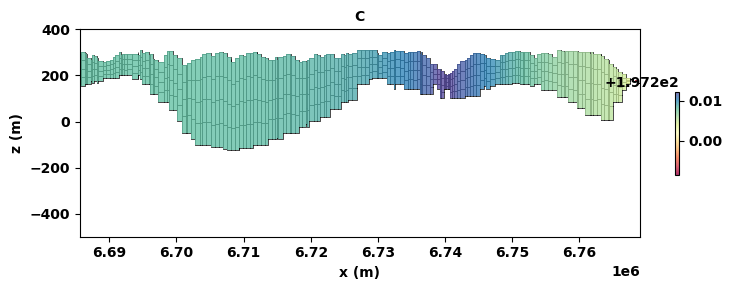

In [49]:
for i in range(len(spatial.xsections)):
    start = spatial.xsections[i][0]
    end   = spatial.xsections[i][1]
    title = spatial.xsection_names[i]

    fm.plot_transect(spatial, 
                     structuralmodel, 
                     array = 'head',  
                     title = title,
                    z0 = -500, z1 = 400, 
                    x0 = start[0], x1 = end[0], 
                    y0 = start[1], y1 = end[1])

### 11. Create and run transient flow model

In [ ]:
scenario = 'transientmodel'
well_q = [-2000, -2000]
data.process_wel(geomodel, mesh, spatial, well_q, wel_qlay)
data.strt = fmss.head
flowmodel = Flowmodel(scenario, project, data, observations, mesh, geomodel)

perlen = 2 * 365 # length of period (days)
nts = 12         # number of time steps for this period
flowmodel.perioddata = [(perlen, nts, 1.1)] # perlen, nts, tsmult

NameError: name 'wel_qlay' is not defined

In [ ]:
sim = flowmodel.write_flowmodel(transient = True, chd = True, wel = True, obs = True, rch = True)

In [ ]:
flowmodel.run_flowmodel(sim, transient = True)

In [ ]:
watertable = flowmodel.get_watertable(geomodel, flowmodel.head)

### 12. Visualise Results

In [ ]:
import plotting_routines

vmin, vmax = 495, 505 #min(flowmodel.head.flatten()), max(flowmodel.head.flatten())
extent = [spatial.x0, spatial.x1, spatial.y0, spatial.y1]
X0, X1, Y0, Y1 = spatial.x0, spatial.x1, 7440000, 7440000
plotting_routines.plot_watertable(spatial, mesh, geomodel, flowmodel, watertable, extent = extent)#, vmin=vmin, vmax=vmax)
plotting_routines.plot_transect(spatial, flowmodel, array, X0, X1, Y0, Y1)#, vmin, vmax)

# PLOT BY LAYER
#from plotting_routines import plot_plan
#array = 'head'
#layer = 0
#plot_plan(spatial, mesh, flowmodel, array, layer, extent = extent, vmin=vmin, vmax=vmax, vectors = True)

### 13. Forecasting

In [ ]:

class Forecast:
    def __init__(self, name):
        self.name = name

forecast = Forecast('forecast_scenario_1')
forecast.qwell = [-200000, -200000] #m3/d 


In [ ]:
scrap code

# FOR TRANSIENT
rch_list = []
for index, row in df.iterrows(): 
    for i in range(4,16): # Jan-Dec
        rch_list.append(row.iloc[i]/1000) # mm to m

nper = len(rch_list)
ncpl = len(cell2d)

# FOR HFB IF WE USE

# import disv2disu # MODFLOW Tools
# Disv2Disu = disv2disu.Disv2Disu    
# nlay = 1
# botm = np.zeros_like(top).reshape(1, len(cell2d))
# idomain = np.ones_like(top).reshape(1, len(cell2d))
# dv2d = Disv2Disu(vertices, cell2d, top, botm, staggered=False, disv_idomain = idomain)
# dv2d._neighbors
# #dv2d._edge_set
# 
# dyke_K, dyke_width = 0.0001, 2  
# hydchr = dyke_K / dyke_width  
# 
# # Set up Horizontal Flow Barrier (HFB)
# for n in range(gdf.shape[0]): # For each dyke...
#     # Vertical
#     for lay in range(nlay):
#         for cell ibd[cell]
#         if zc[lay, icpl] < dyke_top[n]: 
#             hfb.append(([lay, cellid_1], [k, cellid_2], hydchr))

#### FAULT
#P.fault_buffer = 800

# Import fault shape file
#bada_shp = gpd.read_file('../data/shp/badaminna_trace.shp')
#bada_shp.to_crs(epsg=28350, inplace=True)
#bada_shp = gpd.clip(bada_shp, model_boundary)

#from meshing_routines import prepare_fault_nodes_voronoi
#fault_refinement_nodes = prepare_fault_nodes_voronoi(P, '../data/shp/badaminna_trace.shp', model_boundary, inner_boundary)

In [ ]:
import itertools

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation


def data_gen():
    for cnt in itertools.count():
        t = cnt / 10
        yield t, np.sin(2*np.pi*t) * np.exp(-t/10.)


def init():
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlim(0, 1)
    del xdata[:]
    del ydata[:]
    line.set_data(xdata, ydata)
    return line,

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.grid()
xdata, ydata = [], []


def run(data):
    # update the data
    t, y = data
    xdata.append(t)
    ydata.append(y)
    xmin, xmax = ax.get_xlim()

    if t >= xmax:
        ax.set_xlim(xmin, 2*xmax)
        ax.figure.canvas.draw()
    line.set_data(xdata, ydata)

    return line,

# Only save last 100 frames, but run forever
ani = animation.FuncAnimation(fig, run, data_gen, interval=100, init_func=init,
                              save_count=100)
plt.show()

In [ ]:
# METHOD BARDOT 2024
from meshing_routines import resample_linestring
import itertools
from datetime import datetime

t0 = datetime.now()

def voronoi_nodes_gdf(gdf, refinement_boundary_poly, buffer):

    dyke = []
    hfb_1, hfb_2 = [], []
    nodes = []
    
    for n in range(gdf.shape[0]): 
        
        # Dykes notes (on the dyke linestring)
        linestring = dykes_gdf.geometry[n]
        r = 2*buffer/3 # distance between points
        ls_resample = resample_linestring(linestring, r) # resample orginal dyke line
        dyke.append(ls_resample)
        
        # Refinement nodes
        offsets = [-1.5*r, -0.5*r, 0.5*r, 1.5*r]
        fault_offset_lines = []
        for i, offset in enumerate(offsets):
            ls = linestring.parallel_offset(offset) # linestring.parallel_offset
            ls_resample = resample_linestring(ls, r)
            
            p = []
            for point in ls_resample:
                x,y = point.x, point.y
                p.append((x,y))
                #if refinement_boundary_poly.contains(point):
                #    x,y = point.x, point.y
                #    p.append((x,y))
            
            if len(p) != 1: # just incase there is a 1 point linestring
                offset_ls = LineString(p)
                coords = list(offset_ls.coords)
                fault_offset_lines.append(coords) 
                if i == 1: # SIDE 1
                    hfb_1.append(coords)
                if i == 2: # SIDE 2
                    hfb_2.append(coords)
                
        nodes.append([tup for line in fault_offset_lines for tup in line]) 
    refinement_nodes = list(itertools.chain.from_iterable(nodes))

    return(refinement_nodes, hfb_1, hfb_2)

# Import dykes shape file
dykes_gdf = gpd.read_file('../data_shp/dykes_m.shp')
dykes_gdf.to_crs(epsg=28350, inplace=True)
dykes_gdf = gpd.clip(dykes_gdf, inner_boundary_poly).reset_index(drop=True)
#dykes_gdf.plot()

dyke_nodes, hfb_1, hfb_2 = voronoi_nodes_gdf(dykes_gdf, refinement_boundary_poly, buffer)

t1 = datetime.now()
print(t1 - t0) 

In [ ]:

from sklearn.cluster import DBSCAN
from alphashape import alphashape

def create_surfacegeo_polys(geomodel, lith):
    points = []
    a = np.array(mesh.cell2d)
    b = a[geomodel.surf_lith==lith]
    verts = np.unique(b[:,4:7].flatten())
    verts = [int(x) for x in verts]
    vert_coords = []
    for v in verts:
        vert_coords.append(mesh.vertices[v][1:3])
    xlist, ylist = list(zip(*vert_coords))
    gdf = gpd.GeoDataFrame(pd.DataFrame({'x': xlist, 'y': ylist}), 
                           geometry = gpd.points_from_xy(x = xlist, y = ylist))
    # Extract coordinates for clustering
    coords = gdf.geometry.apply(lambda geom: (geom.x, geom.y)).tolist()
    
   # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=5000, min_samples=3)  # eps: max distance for clustering
    gdf['cluster'] = dbscan.fit_predict(coords)
    
    # Create concave hulls for each cluster
    hulls = []
    for cluster_id in gdf['cluster'].unique():
        
        if cluster_id != -1:  # Exclude noise points
            cluster_points = gdf[gdf['cluster'] == cluster_id]
            print('\ncluster id = ', cluster_id, ', number of points = ', len(cluster_points))
            points_list = cluster_points.geometry.apply(lambda p: (p.x, p.y)).tolist()
            
            # CONCAVE
            mp = MultiPoint(points_list)
            gs = gpd.GeoSeries(mp)
            hull = gs.concave_hull(ratio = 0.2, allow_holes = False)
            hulls.append(hull)
    
    hull_gdf = gpd.GeoDataFrame(pd.concat(hulls, ignore_index=True), columns=['geometry'])
    return (gdf, hull_gdf)

def plot_geology_polygons(gdf, hull_gdf):
    # Plot results
    fig, ax = plt.subplots()
    gdf.plot(ax=ax, color='blue', markersize=3, label='Points')
    hull_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1, label='Concave Hulls')
    plt.legend()
    plt.show()

for i in range(7):
    gdf, hull_gdf = create_surfacegeo_polys(geomodel, i)
    plot_geology_polygons(gdf, hull_gdf)

In [ ]:
print(structuralmodel.model.bounding_box.nsteps)
structuralmodel.model.bounding_box.nelements = 1e6
print(structuralmodel.model.bounding_box.nsteps)

# Extract surfaces
surfaces = structuralmodel.model.get_stratigraphic_surfaces()

# Interpolate onto a structured grid
from LoopStructural.interpolators.supports import P1Unstructured2d, StructuredGrid2D
loopmesh = P1Unstructured2d(surfaces[0].triangles, surfaces[0].vertices[:, 0:2], surfaces[0].triangles[:, 0:3]) # Ground is surfaces [0] (ELEMENTS, VERTICES, NEIGHBOURS)
# loopmesh
#dx, dy = 1000, 1000 # 1000m cells
#nx = int((structuralmodel.x1 - structuralmodel.x0)/dx)
#ny = int((structuralmodel.y1 - structuralmodel.y0)/dy)
#structured2d = StructuredGrid2D(origin=[structuralmodel.x0, structuralmodel.y0], nsteps=[nx, ny], step_vector= [dx, dy])
pts = mesh.xcyc  #structured2d.barycentre # replace with my xcyc
z = loopmesh.evaluate_value(pts, surfaces[0].vertices[:, 2])
np.unique(z)
## we expect the values to be close to zero depending on the resultion of the interpolation
#geomodel["Ground"].evaluate_value(np.hstack([pts, z[:, np.newaxis]]))

surface = structuralmodel.model['Ground'].surfaces([0])[0]
#surfaces = structuralmodel.model.get_stratigraphic_surfaces(units = ['Ground'])
p = Loop3DView(structuralmodel.model)
p.plot_model_surfaces()
for s in surfaces:
    p.add_mesh(s.vtk())
p.add_points(surface.vertices)
#p.add_mesh(surfaces[0].vtk)
p.show()

from LoopStructural.visualisation import Loop3DView
p = Loop3DView(structuralmodel.model)
p.plot_model_surfaces()

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, aspect="equal")
pmv = flopy.plot.PlotMapView(modelgrid=geomodel.vgrid)
arr = pmv.plot_array(geomodel.idomain[0], alpha = 0.6) #(M.botm_geo[0], alpha = 0.6)
mesh.tri.plot(ax=ax, edgecolor='black', lw = 0.1)
cbar = fig.colorbar(arr, ax=ax, shrink = 0.5)  